# Batch Analysis of Game Logs

In [1]:
import pandas as pd,numpy as np
import matplotlib.pyplot as plt

import eval7

## Load metadata
- Load metadata and filter for specific games

In [29]:
OUTPUTDIR = './scrimmage_data'

df = pd.read_pickle(f'{OUTPUTDIR}/metadata.pkl')
df.head()

,page,Challenger,C_ELO,Opponent,O_ELO,Creation_Time,Your_bot,Status,C_Score,O_Score,Winner,Game Log,Player Log,game_id
0,1,TwoPocketAces,1801.0,Noganomics,1456.0,2022-01-23 14:32:08.385749,v4 150post 3.6B,Completed,148,-148,TwoPocketAces,24951,24951,24951
1,1,TwoPocketAces,1820.0,lecture-4-reference-bot,1838.0,2022-01-23 05:05:55.308156,v4 150post 3.6B,Completed,0,0,lecture-4-reference-bot,24937,24937,24937
2,1,TwoPocketAces,1796.0,Grand Central,1873.0,2022-01-23 05:04:15.168540,v4 150post 3.6B,Completed,178,-178,TwoPocketAces,24931,24931,24931
3,1,TwoPocketAces,1814.0,Grand Central,1855.0,2022-01-23 05:04:14.442975,v4 150post 3.6B,Completed,-91,91,Grand Central,24930,24930,24930
4,1,TwoPocketAces,1761.0,Grand Central,1908.0,2022-01-23 05:04:09.982104,v4 150post 3.6B,Completed,218,-218,TwoPocketAces,24929,24929,24929


Select games from specified bot version

In [3]:
BOT_NAME = 'v4 150post 3.6B'

mask = (df['Your_bot'] == BOT_NAME)

View matchup frequencies

In [4]:
df.loc[mask,['Challenger','Opponent']].value_counts()

Challenger               Opponent               
Grand Central            TwoPocketAces              60
TwoPocketAces            staff-team                 15
                         Grand Central              12
                         NaruhodoRyuichi            11
Qian & Li                TwoPocketAces              10
lecture-4-reference-bot  TwoPocketAces               9
DeMars DeRover           TwoPocketAces               9
Sweaters & Jetters       TwoPocketAces               9
Invictus                 TwoPocketAces               7
Earls of Sandwich        TwoPocketAces               4
Ace of Spades            TwoPocketAces               4
TwoPocketAces            Sadge                       4
                         lecture-4-reference-bot     3
                         Ace of Spades               3
ahahaha                  TwoPocketAces               2
TwoPocketAces            Mindfulness                 2
                         Sweaters & Jetters          2
                

Select games with a specific challenger

In [30]:
OPP_TEAM = 'Grand Central'

mask_opp = (df['Your_bot'] == BOT_NAME) & ((df['Challenger'] == OPP_TEAM) | (df['Opponent'] == OPP_TEAM))
df[mask_opp].head()

,page,Challenger,C_ELO,Opponent,O_ELO,Creation_Time,Your_bot,Status,C_Score,O_Score,Winner,Game Log,Player Log,game_id
2,1,TwoPocketAces,1796.0,Grand Central,1873.0,2022-01-23 05:04:15.168540,v4 150post 3.6B,Completed,178,-178,TwoPocketAces,24931,24931,24931
3,1,TwoPocketAces,1814.0,Grand Central,1855.0,2022-01-23 05:04:14.442975,v4 150post 3.6B,Completed,-91,91,Grand Central,24930,24930,24930
4,1,TwoPocketAces,1761.0,Grand Central,1908.0,2022-01-23 05:04:09.982104,v4 150post 3.6B,Completed,218,-218,TwoPocketAces,24929,24929,24929
5,1,TwoPocketAces,1789.0,Grand Central,1880.0,2022-01-23 05:04:08.777283,v4 150post 3.6B,Completed,268,-268,TwoPocketAces,24928,24928,24928
6,1,TwoPocketAces,1730.0,Grand Central,1939.0,2022-01-23 05:04:08.491104,v4 150post 3.6B,Completed,409,-409,TwoPocketAces,24927,24927,24927


## Get hands and actions at river

Define parser for game log, for each river:
- Get the button position, hand, board, and post river action of opponent

In [25]:
def analyze_river(output_dict,raw_file,opp_id,our_id):
    '''
    Input game log file
    Output opponent's hands and actions at each river
    '''
    test_str = f'River'
    
    for i,line in enumerate(raw_file):

        if line[:5] == 'River':
            
            # get blinds
            bb_id = raw_file[i-1][0]
            sb_id = raw_file[i-2][0]
            if opp_id == bb_id:
                opp_blinds = 2
                shift_index = 1
            else:
                opp_blinds = 1
                shift_index = 0
            
            # get opponent hands
            bb_hand_line = i - 3
            while raw_file[bb_hand_line][4:8] != 'hand':
                bb_hand_line -= 1
            sb_hand_line = bb_hand_line - 1
                
            hand_line = {2: bb_hand_line, 1: sb_hand_line}[opp_blinds]       
            opp_cards = raw_file[hand_line][11:-2].split(' ')
            
            # get board
            board_cards = line[7:21].split(' ')
            
            # get opponent actions
            action_line = hand_line + 2
            opp_action = raw_file[action_line][2:-1].split(' ')[0]
        
            # store
            output_dict['opp_blind'].append(opp_blinds)
            output_dict['opp_cards'].append(opp_cards)
            output_dict['board_cards'].append(board_cards)
            output_dict['opp_action'].append(opp_action)
            
    return output_dict

Execute parser

In [114]:
from collections import defaultdict

SCRIMMAGE_DIR = './scrimmage_data'
OUR_TEAM = 'TwoPocketAces'
river_actions = defaultdict(list)

for i in range(len(df.loc[mask_opp])):
    
    game = df.loc[mask_opp].iloc[i]

    our_challenge = (game.Challenger == OUR_TEAM)
    our_id = {True: 'A', False: 'B'}[our_challenge]
    opp_id = {True: 'A', False: 'B'}[not our_challenge]

    raw_file = open(f'{SCRIMMAGE_DIR}/game_log_{game.game_id}.txt','r').readlines()

    river_actions = analyze_river(river_actions,raw_file,opp_id,our_id)

print(river_actions.keys())
print("example: ", [river_actions[key][0] for key in river_actions.keys()])

dict_keys(['opp_blind', 'opp_cards', 'board_cards', 'opp_action'])
example:  [1, ['8h', '8s'], ['5d', '2d', 'Ts', 'Kd', '9c'], 'checks']


## Calculate equity for each hand
- For each hand at river, calculate equity vs. a random hand (all cards in range)
- Simply load pickle if data already saved

In [100]:
from itertools import combinations

RANKS = {k:v for k,v in zip('23456789TJQKA',list(range(13)))}
CARDS = {f'{r}{s}': eval7.Card(f'{r}{s}') for r in RANKS.keys() for s in 'schd'}

def get_random_range(opp_hand_str,board_str):    
    rand_cards = [card for card in CARDS.keys() if card not in opp_hand_str + board_str]
    rand_hands = list(combinations(rand_cards,2))                   
    rand_range = eval7.HandRange(", ".join(list(map("".join,rand_hands))))    
    return rand_range

def calculate_equity_vs_random_range(opp_hand_str,board_str):    
    rand_range = get_random_range(opp_hand_str,board_str)    
    opp_hand = tuple(map(eval7.Card,opp_hand_str))
    board = tuple(map(eval7.Card,board_str))
    return eval7.py_hand_vs_range_exact(opp_hand,rand_range,board)

Execute parser in multi-thread
- Could be optimized

In [115]:
from multiprocessing import Pool
from tqdm import tqdm

N_samples = len(river_actions['opp_cards'])
x = range(N_samples)

def f(i):
    return calculate_equity_vs_random_range(river_actions['opp_cards'][i],river_actions['board_cards'][i])
                                            
if __name__ == '__main__':
    with Pool(8) as p:
        r = list(tqdm(p.imap(f,range(N_samples)),total=N_samples))

100%|███████████████████████████████████████| 7826/7826 [20:34<00:00,  6.34it/s]


In [121]:
r_df = pd.DataFrame({'opp_blind': pd.Series(river_actions['opp_blind'],dtype='int'),
                     'opp_equity': pd.Series(r,dtype='float'),
                     'opp_action': pd.Series(river_actions['opp_action'],dtype='str')})

Save batch analysis

In [122]:
r_df.to_pickle('./batch_analysis/GC_Games.pickle')

## Plot batch analysis

In [157]:
r_df.loc[r_df.opp_blind == 1].opp_action.value_counts()

checks    3775
bets      1280
Name: opp_action, dtype: int64

Text(0, 0.5, 'Number of Hands')

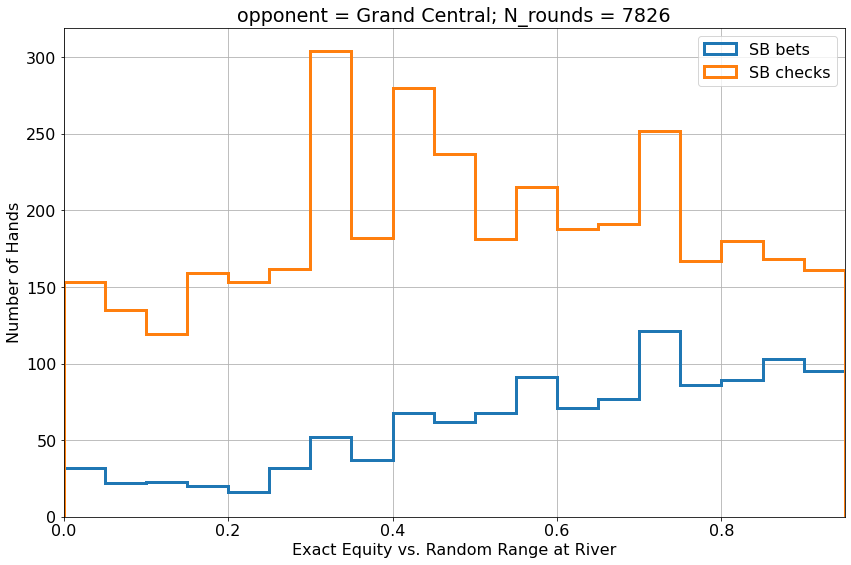

In [154]:
SB = (r_df.opp_blind == 1)
CHECKS = (r_df.opp_action == 'checks')
BETS = (r_df.opp_action == 'bets')

bins = np.arange(0,1,.05)
plt.hist(r_df.loc[SB&BETS].opp_equity,bins,histtype='step',label = 'SB bets',lw=3)
mask = (r_df.opp_blind == 1) & (r_df.opp_action == 'checks')
plt.hist(r_df.loc[SB&CHECKS].opp_equity,bins,histtype='step',label = 'SB checks',lw=3)

plt.legend()
plt.grid()
plt.xlabel('Exact Equity vs. Random Range at River')
plt.title(f'opponent = Grand Central; N_rounds = {N_samples}')
plt.ylabel('Number of Hands')